# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import os
import re
import copy
import time
import datetime as dt
import numpy as np
from workspace_utils import active_session
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

In [4]:
df = spark.read.json('mini_sparkify_event_data.json')

In [5]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [6]:
# measure the shape of dataset
(df.count(), len(df.columns))

(286500, 18)

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [9]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [10]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [11]:
#cleaning NaN values
df.filter(isnull(df['userId'])).count()
df.filter(isnull(df['sessionId'])).count()

0

In [12]:
df.filter(df['userId']=='').count()
df.filter(df['sessionId']=='').count()

0

In [13]:
df_cleaned = df.filter(df['userId']!='')

In [14]:
#df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [15]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [16]:
df_cleaned.createOrReplaceTempView("sparkify_sql")

In [17]:
spark.sql('''
        SELECT DISTINCT(auth)
        FROM sparkify_sql
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [18]:
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_sql
        GROUP BY auth
        ORDER BY user_counts DESC
''').show()

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



In [19]:
group_artist = spark.sql(
    '''
    SELECT artist, count(*) as count
    FROM sparkify_sql
    WHERE artist IS NOT null
    GROUP BY artist
    ORDER BY count(*) desc
    LIMIT 10
    '''
)
group_artist.show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
+--------------------+-----+



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

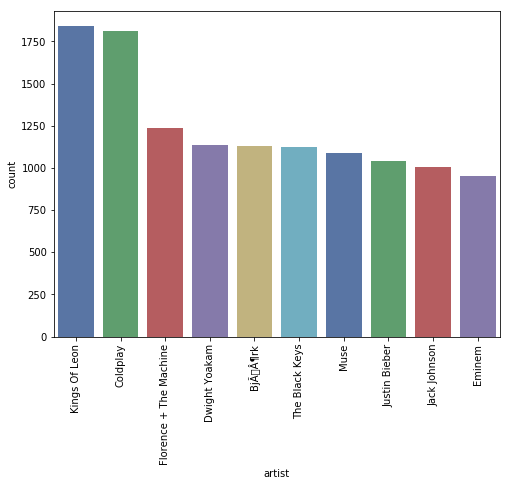

In [20]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x='artist', y='count',palette='deep', data=group_artist.toPandas())
plt.xticks(rotation=90)

In [21]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_sql
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



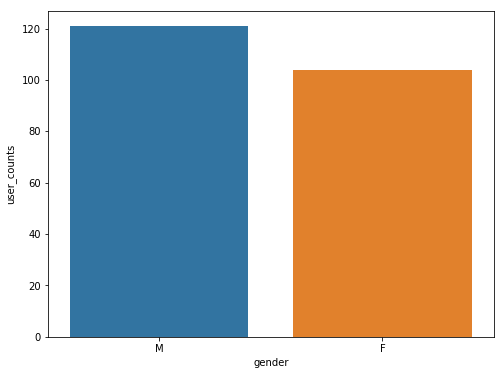

In [22]:
plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='user_counts', data=gender_count.toPandas())
plt.show()

In [23]:
gender_count.drop()

DataFrame[gender: string, user_counts: bigint]

In [24]:
length_data = spark.sql('''
        SELECT length
        FROM sparkify_sql
''')

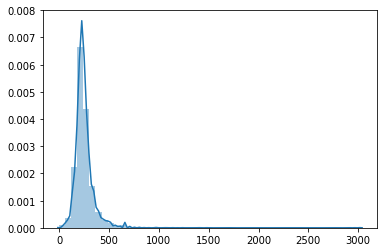

In [25]:
sns.distplot(length_data.toPandas().dropna());

In [26]:
length_data.drop()

DataFrame[length: double]

In [27]:
count_level = spark.sql(
    '''
    SELECT level, count(DISTINCT userId) as count
    FROM sparkify_sql
    GROUP BY level
    ORDER BY count(*) desc
    '''
)

count_level.show()

+-----+-----+
|level|count|
+-----+-----+
| paid|  165|
| free|  195|
+-----+-----+



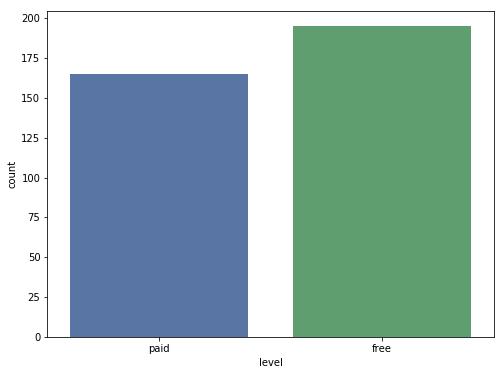

In [28]:
plt.figure(figsize=(8,6))
sns.barplot(x='level', y='count',palette='deep', data=count_level.toPandas())
plt.show()

In [29]:
count_level.drop()

DataFrame[level: string, count: bigint]

In [30]:
count_location = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_sql
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()

In [31]:
#split city and state
count_location = count_location.join(count_location['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)

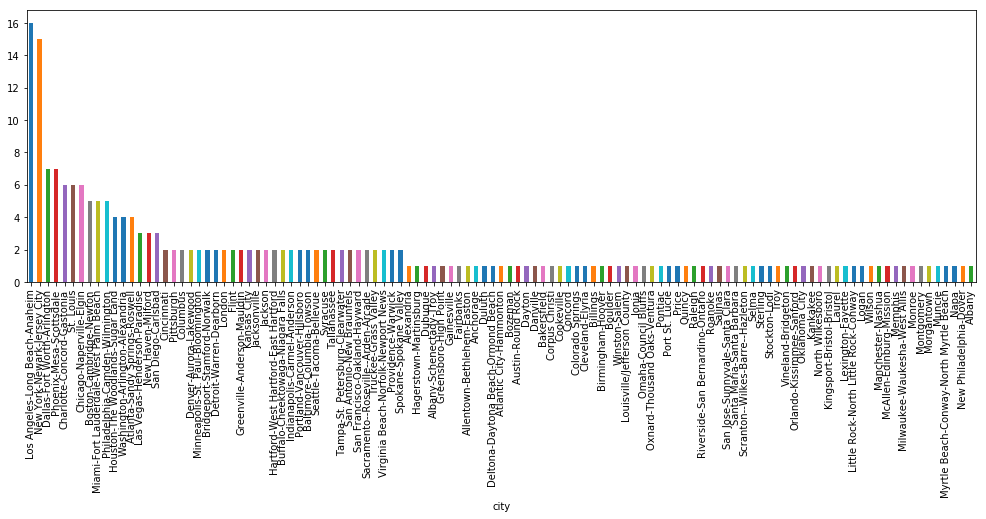

In [32]:
count_location.groupby('city')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5))

Los Angeles and New York are top cities which have the largest user count.

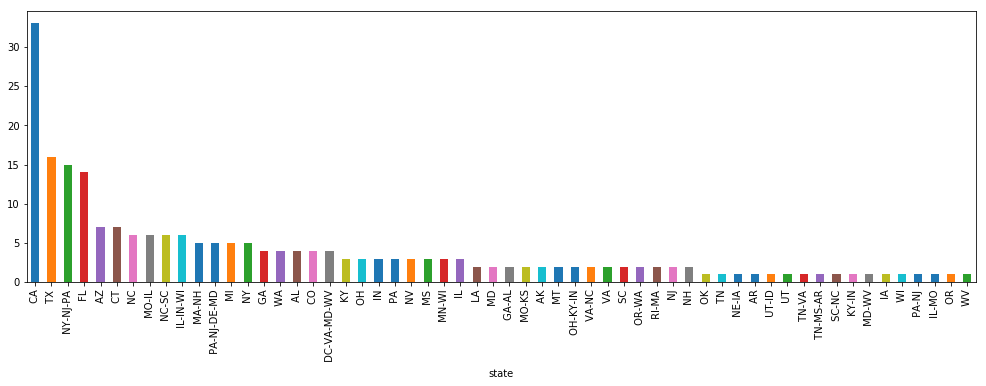

In [33]:
count_location.groupby('state')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

California is the top state has the largest user count.

In [34]:
# method
spark.sql(
    '''
    SELECT DISTINCT method
    FROM sparkify_sql
    ORDER BY method
    '''
).show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



In [35]:
count_method = spark.sql(
    '''
    SELECT method, count(*) as count
    FROM sparkify_sql
    GROUP BY method
    ORDER BY count(*) desc
    '''
).toPandas()

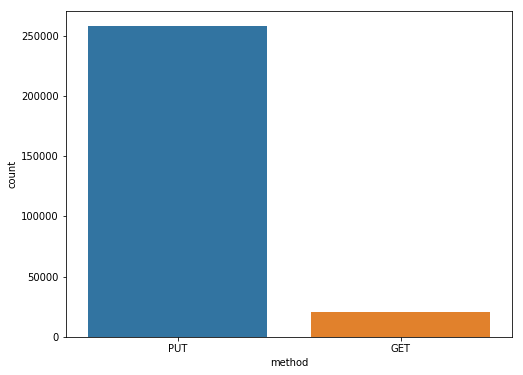

In [36]:
plt.figure(figsize=(8,6))
sns.barplot(x='method', y='count', data=count_method)
plt.show()

In [37]:
count_userAgent = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_sql
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').toPandas()

In [38]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [39]:
count_userAgent['browser'] = count_userAgent['userAgent'].apply(get_browser)


In [40]:
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [41]:
count_userAgent['platform'] = count_userAgent['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)

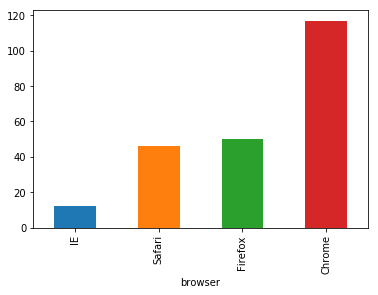

In [42]:
count_userAgent.groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar');

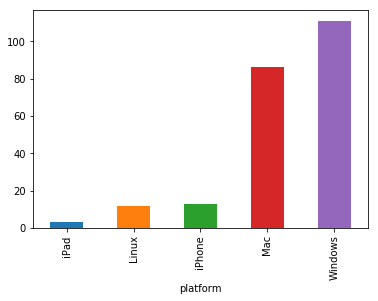

In [43]:
count_userAgent.groupby('platform')['user_counts'].sum().sort_values().plot(kind='bar');

In [44]:
# Page
count_page=spark.sql('''
    SELECT page, count(*) as count
    FROM sparkify_sql
    GROUP BY page
    ORDER BY count(*) desc
    LIMIT 5
    '''
    ).toPandas()

In [45]:
spark.sql(
    '''
    SELECT page, count(*) as count
    FROM sparkify_sql
    GROUP BY page
    ORDER BY count(*) desc
    '''
).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



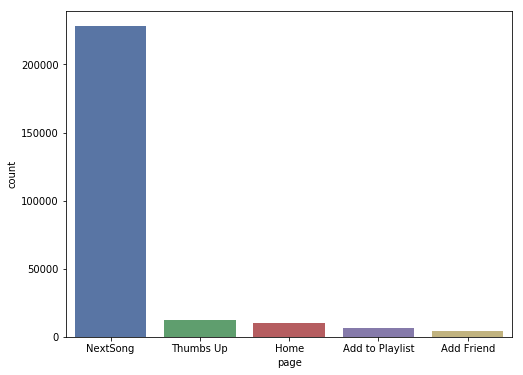

In [46]:
plt.figure(figsize=(8,6))
sns.barplot(x='page', y='count', data=count_page, palette='deep')
plt.show()

In [47]:
count_song = spark.sql(
    '''
    SELECT song, count(*) as count
    FROM sparkify_sql
    WHERE song IS NOT null
    GROUP BY song
    ORDER BY count(*) DESC
    LIMIT 10
    '''
).toPandas()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

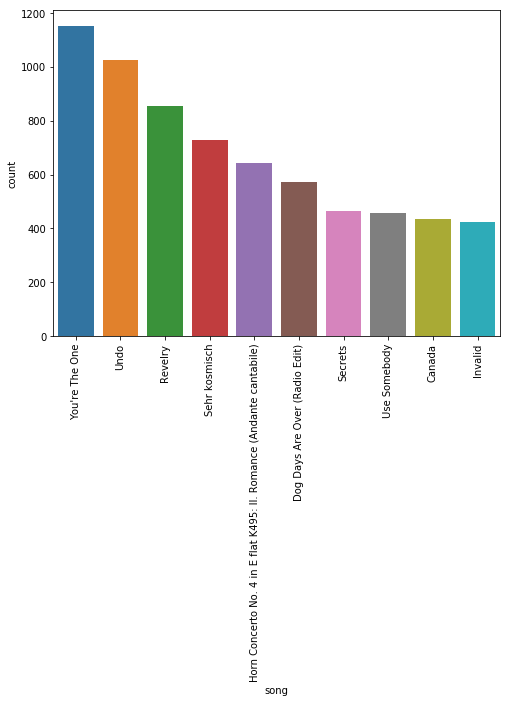

In [48]:
plt.figure(figsize=(8,6))
sns.barplot(x='song', y='count', data=count_song)
plt.xticks(rotation=90)


### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [49]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df_cleaned = df_cleaned.withColumn("time", get_time(df_cleaned.ts))

In [50]:
df_cleaned.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [51]:
#define the flag event udf to transform event to 0 or 1
flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [52]:
#define the current churn or not state
df_cleaned_cancel = df_cleaned.withColumn('Churn_state',flag_event('page'))

In [53]:
from pyspark.sql import Window
from pyspark.sql.functions import max as fmax

In [54]:
#mark the user who have churned event
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_cleaned_cancel = df_cleaned_cancel.withColumn('Churn',fmax('Churn_state').over(userwindow))

In [55]:
df_cleaned_cancel.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=173)]

In [56]:
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



In [57]:
df_cleaned_cancel.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



In [58]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest([32,20],[121,104],alternative='two-sided')

(1.2800974409737422, 0.20051086855629463)

In [59]:
from pyspark.sql.functions import min as fmin
df_cleaned_cancel.select(["Churn", "length"]).groupby(["Churn"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length')).show()

+-----+------------------+------------------+----------+----------+
|Churn|       mean_length|      stdev_length|max_length|min_length|
+-----+------------------+------------------+----------+----------+
|    1|248.63279564406218|102.38497717575477|3024.66567|   4.04853|
|    0|249.20913538880816|  98.6258830014688|3024.66567|   0.78322|
+-----+------------------+------------------+----------+----------+



In [60]:
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



In [61]:
proportions_ztest([8,44],[48,177],alternative='two-sided')

(-1.194176507959015, 0.23240893045643263)

In [62]:
def normalize_data(groupby_data):
    groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
    temp = groupby_series.unstack('Churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]:'result'})
    return df

In [63]:
split_city_state = split(df_cleaned_cancel['location'], ',')
df_cleaned_cancel = df_cleaned_cancel.withColumn('city',split_city_state.getItem(0))
df_cleaned_cancel = df_cleaned_cancel.withColumn('state',split_city_state.getItem(1))

In [64]:
city_data = df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["city","Churn"]).count().sort("city").toPandas()

In [65]:
city_data = normalize_data(city_data)

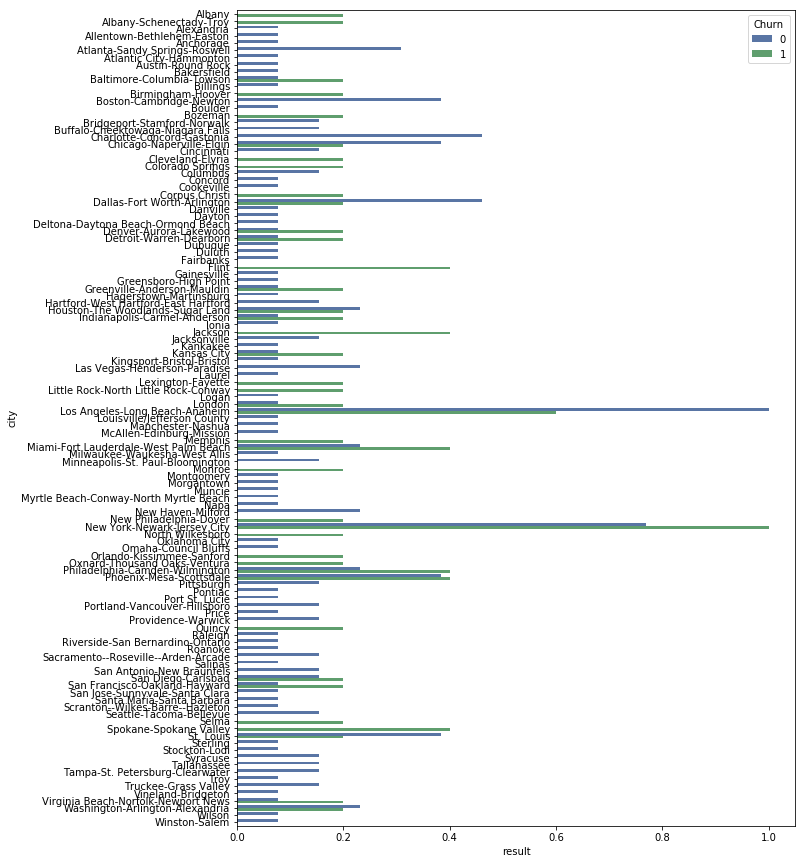

In [66]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="result",y="city", hue="Churn", data=city_data,ax=ax,palette='deep');

In [67]:
state_data = df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["state","Churn"]).count().sort("state").toPandas()

In [68]:
state_data = normalize_data(state_data)

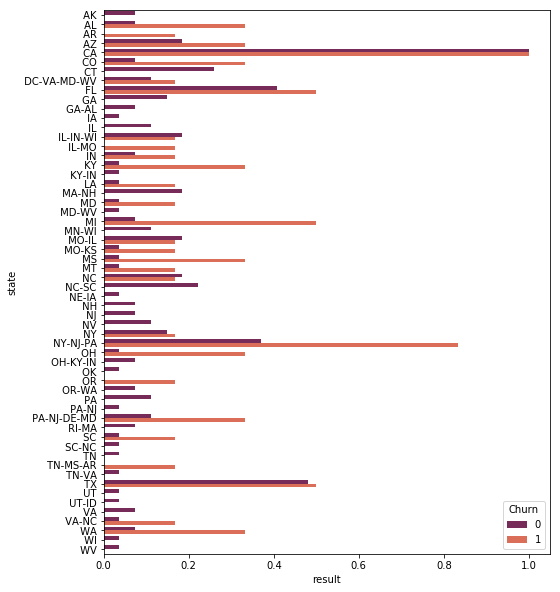

In [69]:
fig, ax = plt.subplots(figsize=(8,10))
sns.barplot( x="result",y="state", hue="Churn", data=state_data,ax=ax,palette='rocket');

In [70]:
df_cleaned_cancel.select(["Churn", "page"]).groupby(["Churn", "page"]).count().sort("page").show()

+-----+--------------------+------+
|Churn|                page| count|
+-----+--------------------+------+
|    1|               About|    56|
|    0|               About|   439|
|    1|          Add Friend|   636|
|    0|          Add Friend|  3641|
|    1|     Add to Playlist|  1038|
|    0|     Add to Playlist|  5488|
|    1|              Cancel|    52|
|    1|Cancellation Conf...|    52|
|    0|           Downgrade|  1718|
|    1|           Downgrade|   337|
|    0|               Error|   220|
|    1|               Error|    32|
|    0|                Help|  1215|
|    1|                Help|   239|
|    0|                Home|  8410|
|    1|                Home|  1672|
|    1|              Logout|   553|
|    0|              Logout|  2673|
|    1|            NextSong| 36394|
|    0|            NextSong|191714|
+-----+--------------------+------+
only showing top 20 rows



In [71]:
count_page_data = df_cleaned_cancel.select(["page","Churn"]).groupby([ "page","Churn"]).count().sort("page").toPandas()
count_page_data = normalize_data(count_page_data)

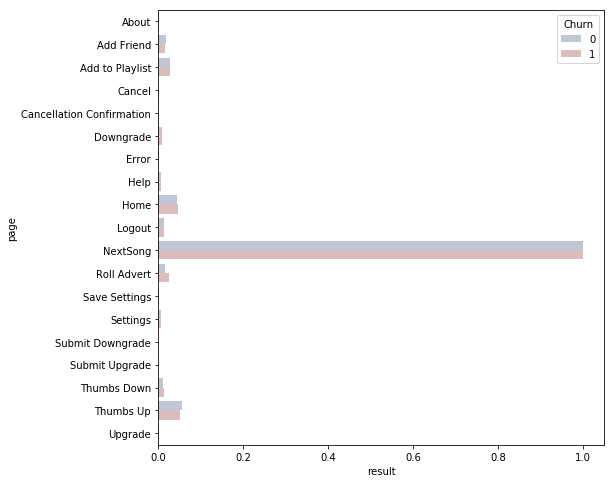

In [72]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="page", hue="Churn", data=count_page_data,ax=ax,palette='vlag');

In [73]:


browser = udf(lambda x : get_browser(x))



In [74]:
#get browsers
df_cleaned_cancel = df_cleaned_cancel.withColumn('browser',browser(df_cleaned_cancel.userAgent))

In [75]:
get_platform = udf(lambda x: platform_dict[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]])

In [76]:
#get platform
df_cleaned_cancel = df_cleaned_cancel.withColumn('platform',get_platform(df_cleaned_cancel.userAgent))

In [77]:
browser_data = df_cleaned_cancel.select(["browser","Churn"]).groupby([ "browser","Churn"]).count().sort("browser").toPandas()

In [78]:
browser_data = normalize_data(browser_data)

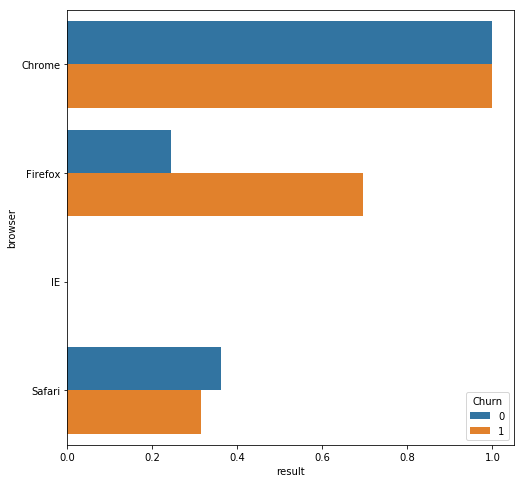

In [79]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="browser", hue="Churn", data=browser_data,ax=ax);

In [80]:
platform_data = df_cleaned_cancel.select(["platform","Churn"]).groupby([ "platform","Churn"]).count().sort("platform").toPandas()

In [81]:
platform_data = normalize_data(platform_data)

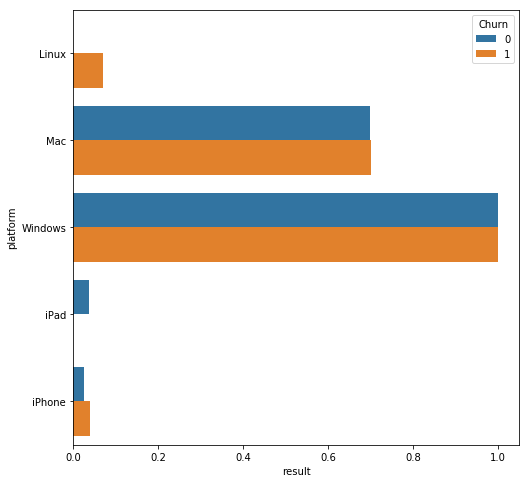

In [82]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="platform", hue="Churn", data=platform_data,ax=ax);

In [83]:
churn_sql = spark.sql(
    '''
    SELECT u.*,
        (CASE WHEN c.userId IS null THEN 0
              ELSE 1
         END) AS churn
    FROM sparkify_sql AS u
    LEFT JOIN 
    (SELECT userId 
     FROM sparkify_sql
     WHERE page = 'Cancellation Confirmation') AS c
    ON u.userId = c.userId
    '''
)

churn_sql.createOrReplaceTempView('churn_sql')

In [84]:
# DataTime Conversion
datetime = udf(lambda x: dt.datetime.fromtimestamp(
    int(x) / 1000).strftime("%Y-%m-%d %H:%M:%S"))
year = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).year)
month = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).month)
weekday = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).weekday())
day = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).day)
hour = udf(lambda x: dt.datetime.fromtimestamp(int(x) / 1000).hour)

spark.udf.register('datetime', datetime)
spark.udf.register('year', year)
spark.udf.register('month', month)
spark.udf.register('weekday', weekday)
spark.udf.register('day', day)
spark.udf.register('hour', hour)

<function __main__.<lambda>(x)>

In [85]:
datetime_data = spark.sql(
    '''
    SELECT userId,
        datetime(registration) AS datetime_registration,
        page,
        datetime(ts) AS datetime_page,
        CAST(year(ts) AS INT) AS year,
        CAST(month(ts) AS INT) AS month,
        CAST(weekday(ts) AS INT) AS weekday,
        CAST(day(ts) AS INT) AS day,
        CAST(hour(ts) AS INT) AS hour
    FROM sparkify_sql
    '''
)

datetime_data.createOrReplaceTempView('datetime_data')

In [86]:
# churn * registration
churn_registration = spark.sql(
    '''
    SELECT d.userId, registration_days, c.churn
    FROM (SELECT userId, DATEDIFF(MAX(datetime_page), MIN(datetime_registration)) AS registration_days
          FROM datetime_data
          GROUP BY userId) as d 
    JOIN (SELECT userId, max(churn) as churn
               FROM churn_sql
               GROUP BY userId) as c
    ON d.userId=c.userId
               
    '''
)

In [87]:
churn_registration.createOrReplaceTempView('churn_registration')

In [88]:
churn_artist_count = spark.sql(
    '''
    SELECT a.userId, a.artist_count, c.churn
    FROM (SELECT userId, COUNT(DISTINCT artist) AS artist_count
          FROM sparkify_sql
          GROUP BY userId) AS a
    JOIN (SELECT userId, max(churn) as churn
               FROM churn_sql
               GROUP BY userId) as c
    ON a.userId=c.userId
    '''
)

In [89]:
churn_artist_count.createOrReplaceTempView('churn_artist_count')

In [90]:
# total_activity
total_activity = spark.sql(
    '''
    SELECT a.userId, a.total_activity, c.churn
    FROM (SELECT userId, COUNT(*) AS total_activity
          FROM sparkify_sql
          GROUP BY userId) AS a
    JOIN (SELECT userId, max(churn) as churn
               FROM churn_sql
               GROUP BY userId) as c
    ON a.userId=c.userId
    '''
)

In [91]:
total_activity.createOrReplaceTempView('total_activity')

In [92]:
# churn*last week activity
churn_week_count = spark.sql(
    '''
    SELECT w.userId, w.week_count, c.churn
    FROM
    (
        SELECT d.userId, COUNT(d.userId) AS week_count        
        FROM datetime_data d
        JOIN 
        (
            SELECT userId, MAX(datetime_page) AS last_datetime
            FROM datetime_data
            GROUP BY userId
        ) AS l
        ON l.userId = d.userId
        WHERE d.datetime_page >= DATE_SUB(l.last_datetime, 7)
        GROUP BY d.userId
    ) AS w
    JOIN (SELECT userId, max(churn) as churn
               FROM churn_sql
               GROUP BY userId) as c
    ON w.userId=c.userId
    '''
)

In [93]:
churn_week_count.createOrReplaceTempView('churn_week_count')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [94]:
extension = ''
for i in ['gender', 'level', 'page']:
    category = spark.sql('''SELECT DISTINCT ''' + i +
                         ''' FROM sparkify_sql''').toPandas()[i].values
    for j in category:
        extension += ', CASE WHEN ' + i + "= '" + j + \
            "' THEN 1 ELSE 0 END AS " + i + '_' + j.replace(' ', '_')

In [95]:
extension = '''SELECT userId, churn ''' + extension + ''' FROM churn_sql'''
extension_table = spark.sql(extension)

In [96]:
extension_table.show()

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+-----

In [97]:
extension_table.createOrReplaceTempView('extension_table')

In [98]:
# sum up records by users
sumup = ''
for i in ['gender', 'level', 'page']:
    category = spark.sql('''SELECT DISTINCT ''' + i +
                         ''' FROM sparkify_sql''').toPandas()[i].values
    for j in category:
        sumup += ', SUM(' + i + '_' + j.replace(' ', '_') + \
            ') AS ' + i + '_' + j.replace(' ', '_')

In [99]:
sumup = '''SELECT userId, SUM(churn) AS churn ''' + \
    sumup + ''' FROM extension_table GROUP BY userId'''

sum_table = spark.sql(sumup)

In [100]:
sum_table.show()

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+-----

In [101]:
sum_table.createOrReplaceTempView('sum_table')

In [102]:
# transform the table, make churn, gender, level 0-1
transform = '''SELECT userId, CASE WHEN Churn > 0 THEN 1 ELSE 0 END AS churn'''
for i in sum_table.columns[2:]:
    if i.split('_')[0] == 'page':
        transform += ', '+i
    else:
        transform += ', CASE WHEN '+i+' >0 THEN 1 ELSE 0 END AS '+i

transform += ' FROM sum_table'

In [103]:
transform_table = spark.sql(transform)

In [104]:
transform_table.show()

+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+--------------+---------+------------+----------+-------------------+
|userId|churn|gender_F|gender_M|level_free|level_paid|page_Cancel|page_Submit_Downgrade|page_Thumbs_Down|page_Home|page_Downgrade|page_Roll_Advert|page_Logout|page_Save_Settings|page_Cancellation_Confirmation|page_About|page_Settings|page_Add_to_Playlist|page_Add_Friend|page_NextSong|page_Thumbs_Up|page_Help|page_Upgrade|page_Error|page_Submit_Upgrade|
+------+-----+--------+--------+----------+----------+-----------+---------------------+----------------+---------+--------------+----------------+-----------+------------------+------------------------------+----------+-------------+--------------------+---------------+-------------+-----

In [105]:
transform_table.createOrReplaceTempView('transform_table')

In [106]:
# bind the table with total_visited_page, artist_count, week_count, registration

final = spark.sql(
    '''
    SELECT transform_table.*,
           churn_registration.registration_days,
           churn_artist_count.artist_count,
           total_activity.total_activity,
           churn_week_count.week_count
    FROM transform_table
    JOIN churn_registration
    ON transform_table.userId=churn_registration.userId
    JOIN churn_artist_count
    ON transform_table.userId=churn_artist_count.userId
    JOIN total_activity
    ON transform_table.userId=total_activity.userId
    JOIN churn_week_count
    ON transform_table.userId=churn_week_count.userId
''')

In [107]:
final.columns

['userId',
 'churn',
 'gender_F',
 'gender_M',
 'level_free',
 'level_paid',
 'page_Cancel',
 'page_Submit_Downgrade',
 'page_Thumbs_Down',
 'page_Home',
 'page_Downgrade',
 'page_Roll_Advert',
 'page_Logout',
 'page_Save_Settings',
 'page_Cancellation_Confirmation',
 'page_About',
 'page_Settings',
 'page_Add_to_Playlist',
 'page_Add_Friend',
 'page_NextSong',
 'page_Thumbs_Up',
 'page_Help',
 'page_Upgrade',
 'page_Error',
 'page_Submit_Upgrade',
 'registration_days',
 'artist_count',
 'total_activity',
 'week_count']

In [108]:
final.createOrReplaceTempView('final')

In [109]:
no_id = '''SELECT '''
for i in final.columns[1:]:
    no_id += i+','

no_id = no_id[:-1]+''' FROM final'''

final = spark.sql(no_id)
final.createOrReplaceTempView('final')

In [110]:
churn_registration.drop()
churn_artist_count.drop()
total_activity.drop()


DataFrame[userId: string, total_activity: bigint, churn: int]

In [111]:
final.printSchema()

root
 |-- churn: integer (nullable = false)
 |-- gender_F: integer (nullable = false)
 |-- gender_M: integer (nullable = false)
 |-- level_free: integer (nullable = false)
 |-- level_paid: integer (nullable = false)
 |-- page_Cancel: long (nullable = true)
 |-- page_Submit_Downgrade: long (nullable = true)
 |-- page_Thumbs_Down: long (nullable = true)
 |-- page_Home: long (nullable = true)
 |-- page_Downgrade: long (nullable = true)
 |-- page_Roll_Advert: long (nullable = true)
 |-- page_Logout: long (nullable = true)
 |-- page_Save_Settings: long (nullable = true)
 |-- page_Cancellation_Confirmation: long (nullable = true)
 |-- page_About: long (nullable = true)
 |-- page_Settings: long (nullable = true)
 |-- page_Add_to_Playlist: long (nullable = true)
 |-- page_Add_Friend: long (nullable = true)
 |-- page_NextSong: long (nullable = true)
 |-- page_Thumbs_Up: long (nullable = true)
 |-- page_Help: long (nullable = true)
 |-- page_Upgrade: long (nullable = true)
 |-- page_Error: long 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [112]:
cols=['artist_count', 'gender_F', 'gender_M', 'level_free', 'level_paid', 'page_About', 'page_Add_Friend', 'page_Add_to_Playlist', 'page_Downgrade', 'page_Error', 'page_Help', 'page_Home', 'page_Logout', 'page_NextSong', 'page_Roll_Advert', 'page_Save_Settings', 'page_Settings', 'page_Submit_Downgrade', 'page_Submit_Upgrade', 'page_Thumbs_Down', 'page_Thumbs_Up', 'page_Upgrade', 'registration_days', 'total_activity', 'week_count']

In [113]:
assembler = VectorAssembler(inputCols=cols, outputCol='features')
df = assembler.transform(final)

In [114]:
final.drop()

DataFrame[churn: int, gender_F: int, gender_M: int, level_free: int, level_paid: int, page_Cancel: bigint, page_Submit_Downgrade: bigint, page_Thumbs_Down: bigint, page_Home: bigint, page_Downgrade: bigint, page_Roll_Advert: bigint, page_Logout: bigint, page_Save_Settings: bigint, page_Cancellation_Confirmation: bigint, page_About: bigint, page_Settings: bigint, page_Add_to_Playlist: bigint, page_Add_Friend: bigint, page_NextSong: bigint, page_Thumbs_Up: bigint, page_Help: bigint, page_Upgrade: bigint, page_Error: bigint, page_Submit_Upgrade: bigint, registration_days: int, artist_count: bigint, total_activity: bigint, week_count: bigint]

In [115]:
transform_table.drop()

DataFrame[userId: string, churn: int, gender_F: int, gender_M: int, level_free: int, level_paid: int, page_Cancel: bigint, page_Submit_Downgrade: bigint, page_Thumbs_Down: bigint, page_Home: bigint, page_Downgrade: bigint, page_Roll_Advert: bigint, page_Logout: bigint, page_Save_Settings: bigint, page_Cancellation_Confirmation: bigint, page_About: bigint, page_Settings: bigint, page_Add_to_Playlist: bigint, page_Add_Friend: bigint, page_NextSong: bigint, page_Thumbs_Up: bigint, page_Help: bigint, page_Upgrade: bigint, page_Error: bigint, page_Submit_Upgrade: bigint]

In [116]:
df_cleaned.drop()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, time: string]

In [117]:
scaler = StandardScaler(inputCol='features',
                        outputCol='features_scale', withStd=True)
df = scaler.fit(df).transform(df)

In [118]:
# select features and churn label
df = df.select(df.churn.alias('label'), df.features_scale.alias('features'))

In [119]:
df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.41725179202960...|
|    0|[0.56130300594458...|
|    1|(25,[0,2,3,13,14,...|
|    0|[3.69565872940505...|
|    1|[2.29322909508333...|
|    0|[0.23511807328652...|
|    0|[2.15580092548628...|
|    1|[2.88764732261757...|
|    0|[1.06465437410728...|
|    1|[0.38579233151943...|
|    0|[2.15083364224783...|
|    0|(25,[0,1,3,6,7,10...|
|    1|[2.05479949963784...|
|    0|[0.88417641644368...|
|    0|[2.20547375787076...|
|    0|[3.42742543452888...|
|    1|[0.34274254345288...|
|    1|[2.98699298738652...|
|    0|[1.43223333375240...|
|    0|[0.32287341049909...|
+-----+--------------------+
only showing top 20 rows



In [120]:
# split train, test and validation
train, test = df.randomSplit([0.7, 0.3])
valid, test = test.randomSplit([0.5, 0.5])

In [121]:
# Logistic Regression
lr = LogisticRegression()
evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_grid = ParamGridBuilder().build()
cv = CrossValidator(estimator=lr,
                    evaluator=evaluator,
                    estimatorParamMaps=param_grid,
                    numFolds=5)

In [122]:
with active_session():
    cv_fit=cv.fit(train)

In [123]:
with active_session():
    lr_pred=cv_fit.transform(test)

In [124]:
# show cv performance
print('Accuracy: ', evaluator.evaluate(
    lr_pred, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(lr_pred, {evaluator.metricName: 'f1'}))

Accuracy:  0.8235294117647058
F1 Score:  0.8109803921568628


In [125]:
# using best model of cv to validate
lr_best = cv_fit.bestModel
lr_best.extractParamMap()

{Param(parent='LogisticRegression_3bc2047c517a', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_3bc2047c517a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_3bc2047c517a', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_3bc2047c517a', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_3bc2047c517a', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_3bc2047c517a', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_3bc2047c517a', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [126]:
# using best model of cv to validate
lr_valid = cv_fit.transform(valid)
print('Accuracy: ', evaluator.evaluate(
    lr_valid, {evaluator.metricName: 'accuracy'}))
print('F1 Score: ', evaluator.evaluate(lr_valid, {evaluator.metricName: 'f1'}))

Accuracy:  0.8636363636363636
F1 Score:  0.8636363636363635


In [127]:
# Gradient Boosting
gb = GBTClassifier(seed=0)
param_grid_gb = ParamGridBuilder().build()
cv_gb = CrossValidator(estimator=gb,
                       evaluator=evaluator,
                       estimatorParamMaps=param_grid_gb,
                       numFolds=5)

In [128]:
# fit train and predict test
with active_session():
    gb_fit=cv_gb.fit(train)
    gb_pred = gb_fit.transform(test)


In [129]:
with active_session():
    gb_valid = gb_fit.transform(valid)

In [130]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC

In [131]:
with active_session():
        svc = LinearSVC()
        param_grid_svc = ParamGridBuilder().build()
        cv_svc = CrossValidator(estimator=svc,
                                evaluator=evaluator,
                                estimatorParamMaps=param_grid_svc,
                                numFolds=5)


In [132]:
# fit train and predict test
with active_session():
    svc_fit=cv_svc.fit(train)
    svc_pred = svc_fit.transform(test)


In [133]:
# using best model of cv to validate
with active_session():
    svc_valid = svc_fit.transform(valid)
    print('Accuracy: ', evaluator.evaluate(
        svc_valid, {evaluator.metricName: 'accuracy'}))
    print('F1 Score: ', evaluator.evaluate(
        svc_valid, {evaluator.metricName: 'f1'}))


Accuracy:  0.8863636363636364
F1 Score:  0.8819362455726091


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.